# DEPLOY SISTEM TIMESERIES NO2

# Mengambil dan membaca data NO2 Bangkalan
Kode di bawah digunakan untuk membaca file CSV berisi data kadar NO₂ menggunakan pustaka pandas di Python. Pertama, path file didefinisikan dalam variabel DATA_PATH, kemudian fungsi pd.read_csv() digunakan untuk memuat data ke dalam sebuah DataFrame bernama df. Program menampilkan lima baris pertama dataset menggunakan df.head(), informasi struktur data (seperti jumlah kolom, tipe data, dan nilai non-null) dengan df.info(), serta ringkasan statistik deskriptif seperti rata-rata, standar deviasi, dan nilai maksimum menggunakan df.describe(). Blok try-except digunakan untuk menangani kemungkinan kesalahan seperti file tidak ditemukan atau format CSV yang tidak sesuai, sehingga program tidak langsung berhenti saat terjadi error.

In [ ]:
import pandas as pd

# Path ke file CSV
DATA_PATH = "/content/NO2_Bangkalan.csv"

try:
    # Membaca data CSV
    df = pd.read_csv(DATA_PATH)

    # Tampilkan beberapa baris awal
    print("📊 Data Awal NO₂ Bangkalan:")
    print(df.head())

    # Tampilkan informasi umum dataset
    print("\n🧭 Info Dataset:")
    print(df.info())

    # Tampilkan statistik dasar
    print("\n📈 Deskripsi Statistik:")
    print(df.describe())

except FileNotFoundError:
    print(f" File tidak ditemukan di path: {DATA_PATH}")
except Exception as e:
    print(f" Terjadi kesalahan saat membaca CSV: {e}")

# Prediksi Konsentrasi NO₂ Multi-Hari Menggunakan K-Nearest Neighbors (KNN) Regressor

Kode di atas merupakan implementasi model machine learning berbasis K-Nearest Neighbors (KNN) Regressor untuk memprediksi konsentrasi gas Nitrogen Dioksida (NO₂) secara multi-hari. Dataset yang digunakan berisi data waktu dan nilai konsentrasi NO₂, yang terlebih dahulu dibersihkan dari nilai kosong dan dikonversi ke format waktu yang sesuai. Untuk menangkap pola temporal, dibuat fitur lag (lag_1, lag_2, lag_3) yang merepresentasikan nilai NO₂ pada tiga periode sebelumnya. Selain itu, fitur waktu tambahan seperti hour, dayofyear, dan time_numeric juga diekstraksi agar model mampu mengenali tren musiman dan perubahan harian.

Setelah proses normalisasi menggunakan MinMaxScaler, data dibagi menjadi data latih dan uji. Model KNN kemudian dilatih untuk menemukan hubungan antara fitur waktu dan nilai NO₂. Evaluasi dilakukan menggunakan metrik Mean Squared Error (MSE), R² Score, dan Mean Absolute Percentage Error (MAPE) untuk menilai kinerja model. Hasil pelatihan menunjukkan bahwa model dapat digunakan untuk melakukan peramalan ke depan secara berurutan menggunakan fungsi predict_future(days). Fungsi ini menghasilkan prediksi kadar NO₂ beberapa hari mendatang dengan memperbarui nilai lag setiap iterasi. Model dan scaler juga disimpan dalam folder model/ agar dapat digunakan kembali pada aplikasi prediksi berbasis web atau sistem monitoring kualitas udara.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import os

# === 1. Load dataset ===
data_path = 'data/NO2_bangkalan.csv'
data = pd.read_csv(data_path)

# === 2. Konversi kolom waktu ===
data['time'] = pd.to_datetime(data['time'], errors='coerce')
data = data.dropna(subset=['time'])

# === 3. Tangani nilai kosong dan tipe data ===
data['NO2'] = pd.to_numeric(data['NO2'], errors='coerce')
data = data.dropna(subset=['NO2'])

# === 4. Buat fitur lag untuk memperbaiki autokorelasi ===
for lag in range(1, 4):  # gunakan 3 lag terakhir
    data[f'lag_{lag}'] = data['NO2'].shift(lag)
data = data.dropna()

# === 5. Ekstrak fitur waktu tambahan ===
data['hour'] = data['time'].dt.hour
data['dayofyear'] = data['time'].dt.dayofyear
data['time_numeric'] = (data['time'] - data['time'].min()).dt.total_seconds()

# === 6. Siapkan fitur dan target ===
X = data[['time_numeric', 'hour', 'dayofyear', 'lag_1', 'lag_2', 'lag_3']]
y = data['NO2']

# === 7. Normalisasi data ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# === 8. Split data latih dan uji ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=False
)

# === 9. Latih model KNN ===
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# === 10. Evaluasi model ===
y_pred = knn.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(" Model KNN berhasil dilatih tanpa error!")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Jumlah data setelah dibersihkan: {len(data)} baris")

# === 11. Simpan model dan scaler ===
os.makedirs('model', exist_ok=True)
joblib.dump(knn, 'model/knn_model.pkl')
joblib.dump(scaler, 'model/scaler.pkl')

print(" Model dan scaler telah disimpan di folder 'model/'")

# === 12. Fungsi prediksi multi-hari ===
def predict_future(days=1):
    """
    Memprediksi nilai NO2 untuk beberapa hari ke depan.
    """
    future_preds = []
    last_rows = data.iloc[-3:].copy()

    for d in range(days):
        new_time = last_rows['time'].iloc[-1] + pd.Timedelta(hours=24)
        new_features = {
            'time_numeric': (new_time - data['time'].min()).total_seconds(),
            'hour': new_time.hour,
            'dayofyear': new_time.dayofyear,
            'lag_1': last_rows['NO2'].iloc[-1],
            'lag_2': last_rows['NO2'].iloc[-2],
            'lag_3': last_rows['NO2'].iloc[-3],
        }
        X_new = scaler.transform(pd.DataFrame([new_features]))
        pred = knn.predict(X_new)[0]
        future_preds.append((new_time, pred))

        # Update untuk prediksi berikutnya
        new_row = pd.DataFrame({'time': [new_time], 'NO2': [pred]})
        last_rows = pd.concat([last_rows, new_row]).iloc[-3:]

    return pd.DataFrame(future_preds, columns=['Tanggal', 'Prediksi_NO2'])

# Simpan hasil prediksi 7 hari ke depan
future_df = predict_future(days=7)
print("\n Prediksi 7 Hari ke Depan:")
print(future_df)


# Preprocessing Data Waktu untuk Model Prediksi NO₂

Kode di atas berfungsi untuk melakukan pra-pemrosesan (preprocessing) terhadap data masukan sebelum digunakan oleh model prediksi K-Nearest Neighbors (KNN). Fungsi preprocess_input() menerima sebuah DataFrame yang memiliki kolom waktu (time), kemudian mengubahnya menjadi fitur numerik yang sesuai dengan format pelatihan model. Proses dimulai dengan memuat scaler dan dataset referensi asli yang digunakan saat pelatihan. Nilai waktu diubah menjadi format datetime, lalu dihitung dalam satuan detik sejak waktu paling awal di dataset. Selain itu, fitur tambahan seperti hour (jam) dan dayofyear (hari ke-n dalam setahun) dibuat agar model dapat menangkap pola harian dan musiman.

Setelah fitur-fitur tersebut dibuat, data diurutkan agar urutannya sesuai dengan data pelatihan (time_numeric, hour, dayofyear), kemudian dilakukan normalisasi menggunakan MinMaxScaler yang sebelumnya disimpan. Hasil akhirnya berupa data yang sudah siap untuk dimasukkan ke model KNN tanpa menyebabkan error ketidaksesuaian fitur. Dengan fungsi ini, sistem prediksi dapat menerima input waktu baru dari pengguna dan secara otomatis mengonversinya ke dalam bentuk numerik dan terstandarisasi, memastikan prediksi konsentrasi NO₂ tetap akurat dan konsisten dengan model pelatihan.

In [ ]:
import pandas as pd
import joblib

def preprocess_input(df):
    """
    Mengubah kolom 'time' menjadi fitur numerik (detik sejak awal dataset),
    serta menambahkan fitur waktu tambahan agar sesuai dengan model KNN.
    """
    # Load scaler dan dataset referensi
    scaler = joblib.load('model/scaler.pkl')
    data_ref = pd.read_csv('data/NO2_bangkalan.csv')
    data_ref['time'] = pd.to_datetime(data_ref['time'], errors='coerce')

    # Gunakan waktu awal dataset sebagai anchor
    t0 = data_ref['time'].min()

    # Pastikan format waktu valid
    df['time'] = pd.to_datetime(df['time'], errors='coerce')
    if df['time'].isna().any():
        raise ValueError("Format waktu tidak valid. Gunakan format YYYY-MM-DD HH:MM:SS")

    # Buat fitur tambahan sesuai model
    df['hour'] = df['time'].dt.hour
    df['dayofyear'] = df['time'].dt.dayofyear
    df['time_numeric'] = (df['time'] - t0).dt.total_seconds()

    # Urutkan kolom sesuai urutan saat training
    X = df[['time_numeric', 'hour', 'dayofyear']]

    # Normalisasi menggunakan scaler yang sama
    processed = scaler.transform(X)

    return processed


# Aplikasi Prediksi Kadar NO₂ Berbasis Waktu Menggunakan KNN dengan Streamlit

Kode di atas membangun sebuah aplikasi web interaktif berbasis Streamlit yang digunakan untuk memprediksi kadar gas Nitrogen Dioksida (NO₂) di udara menggunakan model K-Nearest Neighbors (KNN) Regressor. Aplikasi ini terdiri dari dua bagian utama: prediksi ke depan dan evaluasi model. Pada bagian prediksi, pengguna dapat memilih tanggal awal dan menentukan berapa hari ke depan yang ingin diprediksi (hingga 7 hari). Sistem kemudian memproses tanggal tersebut menjadi fitur numerik menggunakan fungsi preprocess_input(), melakukan normalisasi dengan scaler yang sama seperti saat pelatihan, dan menghasilkan estimasi kadar NO₂ dalam satuan µg/m³. Hasil prediksi disajikan dalam bentuk tabel serta grafik tren perubahan kadar NO₂ agar pengguna mudah memahami hasilnya.

Bagian kedua dari aplikasi digunakan untuk evaluasi performa model KNN menggunakan dataset historis asli. Sistem menghitung tiga metrik utama — Mean Squared Error (MSE), R² Score, dan Mean Absolute Percentage Error (MAPE) — yang menggambarkan tingkat kesalahan dan akurasi model. Selain itu, grafik perbandingan antara nilai aktual dan hasil prediksi juga ditampilkan agar pengguna dapat menilai kesesuaian model secara visual. Aplikasi ini menjadi implementasi nyata dari konsep time series forecasting berbasis pembelajaran mesin, yang dapat dimanfaatkan untuk pemantauan kualitas udara secara berkelanjutan dan pengambilan keputusan lingkungan.

In [ ]:
import streamlit as st
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

# ===============================
# Fungsi Preprocessing Input (disamakan dengan training)
# ===============================
def preprocess_input(df):
    df = df.copy()
    df['time'] = pd.to_datetime(df['time'], errors='coerce')
    df['hour'] = df['time'].dt.hour
    df['dayofyear'] = df['time'].dt.dayofyear
    df['time_numeric'] = (df['time'] - df['time'].min()).dt.total_seconds()

    # Buat kolom lag dummy (karena data masa depan tidak punya NO2)
    df['lag_1'] = 0
    df['lag_2'] = 0
    df['lag_3'] = 0

    return df[['time_numeric', 'hour', 'dayofyear', 'lag_1', 'lag_2', 'lag_3']]

# ===============================
# Load model dan scaler
# ===============================
model = joblib.load('model/knn_model.pkl')
scaler = joblib.load('model/scaler.pkl')

# ===============================
# Konfigurasi Halaman
# ===============================
st.set_page_config(
    page_title="Prediksi Kadar NO₂ - KNN",
    page_icon="🌫️",
    layout="wide"
)

# Judul utama
st.markdown("<h1 style='text-align: center;'>🌫️ Prediksi Kadar NO₂ Menggunakan KNN</h1>", unsafe_allow_html=True)
st.markdown("<p style='text-align: center;'>Aplikasi ini memprediksi kadar NO₂ berdasarkan waktu pengamatan dan menampilkan evaluasi model.</p>", unsafe_allow_html=True)

st.divider()

# ===============================
# Bagian 1 — Prediksi ke Depan
# ===============================
st.subheader("📅 Prediksi Kadar NO₂ 7 Hari ke Depan")

with st.container():
    col1, col2 = st.columns([2, 1])
    with col1:
        start_date = st.date_input(
            "Pilih Tanggal Awal Prediksi",
            pd.Timestamp.now().date()
        )
    with col2:
        pred_days = st.slider("Rentang Prediksi (hari ke depan)", 1, 7, 7)

    st.markdown("<div style='text-align: center; margin-top: 15px;'>", unsafe_allow_html=True)
    predict_button = st.button("🔍 Prediksi 7 Hari ke Depan", use_container_width=True)
    st.markdown("</div>", unsafe_allow_html=True)

    if predict_button:
        try:
            # Membuat rentang waktu dari tanggal awal ke beberapa hari ke depan
            time_range = pd.date_range(start=start_date, periods=pred_days, freq='D')

            # Membuat DataFrame untuk diproses
            df_future = pd.DataFrame({'time': time_range})

            # Ubah waktu ke fitur numerik sesuai preprocessing
            df_future_processed = preprocess_input(df_future)

            # Normalisasi data
            df_future_scaled = scaler.transform(df_future_processed)

            # Prediksi kadar NO₂
            predictions = model.predict(df_future_scaled)

            # Tampilkan hasil dalam tabel
            st.markdown("### 📊 Hasil Prediksi")
            results_df = pd.DataFrame({
                'Tanggal': time_range,
                'Perkiraan NO₂ (µg/m³)': predictions
            })
            st.dataframe(results_df.style.format({'Perkiraan NO₂ (µg/m³)': '{:.2f}'}), use_container_width=True)

            # Grafik prediksi ke depan
            st.markdown("### 📈 Grafik Prediksi 7 Hari ke Depan")
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.plot(results_df['Tanggal'], results_df['Perkiraan NO₂ (µg/m³)'], marker='o', linestyle='-', color='teal')
            ax.set_title(f"Prediksi Kadar NO₂ untuk {pred_days} Hari ke Depan")
            ax.set_xlabel("Tanggal")
            ax.set_ylabel("Kadar NO₂ (µg/m³)")
            ax.grid(True)
            st.pyplot(fig)

        except Exception as e:
            st.error(f"Terjadi kesalahan: {e}")

st.divider()

# ===============================
# Bagian 2 — Evaluasi Model
# ===============================
st.subheader("📊 Evaluasi Model KNN")

with st.container():
    col_data, col_eval = st.columns([2, 3])

    with col_data:
        data = pd.read_csv('data/NO2_bangkalan.csv')
        data['time'] = pd.to_datetime(data['time'], errors='coerce')
        data['NO2'] = pd.to_numeric(data['NO2'], errors='coerce')
        data = data.dropna(subset=['time', 'NO2'])

        # Buat fitur waktu dan lag seperti saat training
        data['hour'] = data['time'].dt.hour
        data['dayofyear'] = data['time'].dt.dayofyear
        data['time_numeric'] = (data['time'] - data['time'].min()).dt.total_seconds()

        # Tambahkan lag (sama dengan training)
        for lag in range(1, 4):
            data[f'lag_{lag}'] = data['NO2'].shift(lag)

        # Hapus baris dengan NaN akibat lag
        data = data.dropna()

        # Siapkan fitur dan target
        X = data[['time_numeric', 'hour', 'dayofyear', 'lag_1', 'lag_2', 'lag_3']]
        y = data['NO2']

        # Normalisasi dengan scaler
        X_scaled = scaler.transform(X)
        y_pred = model.predict(X_scaled)

        # Hilangkan nilai NaN
        mask = (~pd.isna(y)) & (~pd.isna(y_pred))
        y, y_pred = y[mask], y_pred[mask]

        # Hitung metrik
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        mape = mean_absolute_percentage_error(y, y_pred) * 100

    with col_eval:
        st.markdown("### 📈 Hasil Evaluasi Model")
        col1, col2, col3 = st.columns(3)
        col1.metric("📉 MSE", f"{mse:.2f}")
        col2.metric("📈 R²", f"{r2:.3f}")
        col3.metric("📊 MAPE (%)", f"{mape:.2f}%")

st.markdown("---")

# Grafik aktual vs prediksi
st.subheader("📈 Grafik Prediksi vs Aktual")
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data['time'], y, label='Aktual', linewidth=2)
ax.plot(data['time'], y_pred, label='Prediksi (KNN)', linestyle='--')
ax.set_xlabel("Waktu")
ax.set_ylabel("Kadar NO₂ (µg/m³)")
ax.legend()
ax.grid(True)
st.pyplot(fig)

st.divider()
st.caption("Oleh NURIL ANJAR ROYANI — KNN Regressor untuk Prediksi Kadar NO₂")


# Tampilan UI

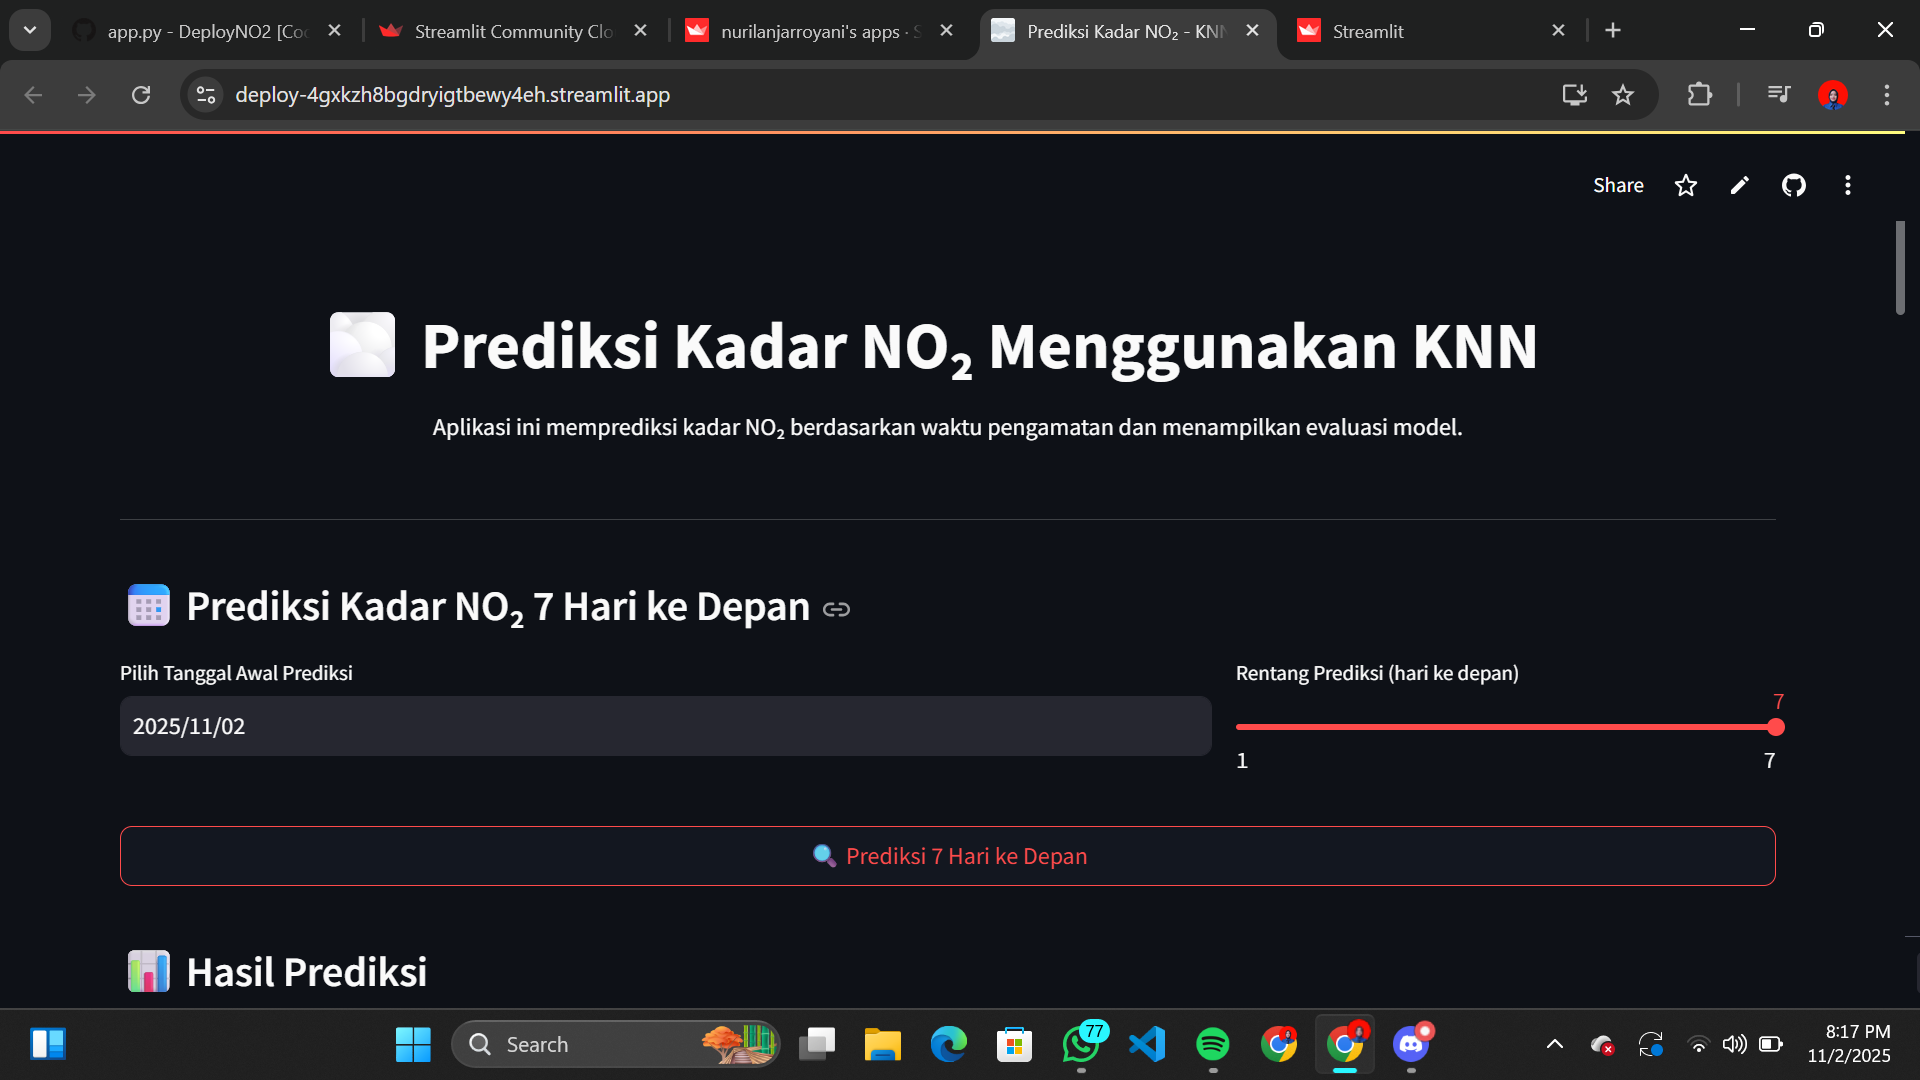

# Link Streamlit
https://deploy-4gxkzh8bgdryigtbewy4eh.streamlit.app/